# DATA STORYTELLING (UPDATED)

Note: I've updated my dataset to the latest one provided by Toronto Police including data from 2019.
<p>The dataset explored in this project is the KSI - Killed or Seriously Injured data from the Toronto Police Service. This data provides details on the serious incident occurring in the city over the span of 11 years from 2008 to 2019. After carrying out the data wrangling process, we will now be exploring the data for analysis and observable trends.</p>

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import ipywidgets
import geocoder
import geopy
from sklearn.cluster import KMeans

In [3]:
#import the data file for KSI - Killed or Seriously Injured from the Toronto Police Service webstie
data = pd.read_csv('ksidataupdated.csv', index_col = 0)
data.VEHTYPE.unique()

array(['Unknown/Other', 'Automobile, Station Wagon', 'Passenger Van',
       'Municipal Transit Bus (TTC)', 'Taxi', 'Motorcycle', 'Bicycle',
       'Truck - Open', 'Delivery Van', 'Moped', 'Police Vehicle',
       'Pick Up Truck', 'Truck-Tractor', 'Street Car',
       'Truck - Closed (Blazer, etc)', 'Bus (Other) (Go Bus, Gray Coach)',
       'Intercity Bus', 'Construction Equipment', 'Truck - Dump',
       'Off Road - 2 Wheels', 'Truck (other)', 'Truck - Tank',
       'Fire Vehicle', 'School Bus', 'Tow Truck',
       'Other Emergency Vehicle', 'Truck - Car Carrier'], dtype=object)

## EXPLORING THE DATA

### I. BY YEAR/MONTH/DAY OF THE WEEK/TIME

First we will have a look at the data of the accidents by the time of occurrence to determine if there is a specific year/month/day of the week/time where serious incident are more likely to occur.

#### BY YEAR

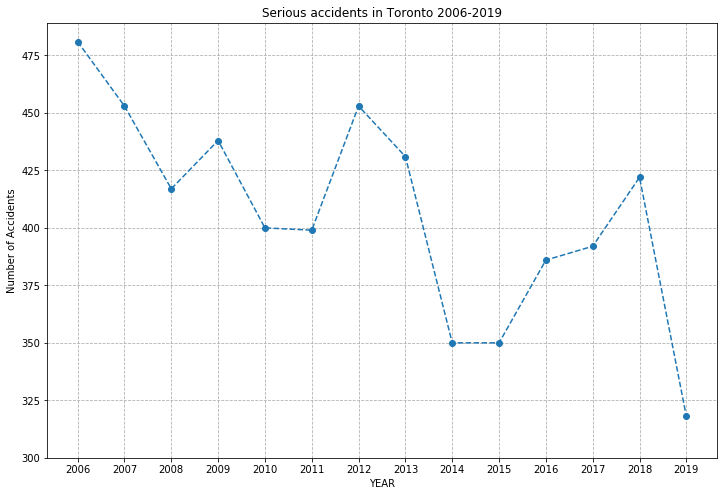

In [12]:
#Find no. of accident by year, use of the drop duplicates function since some accidents are are recorded more than once
data.index = pd.to_datetime(data.index)
trend = data[['ACCNUM']].drop_duplicates()
yeartrend = trend.groupby([trend.index.year]).count()
fig, ax = plt.subplots(figsize=(12,8))
fig = plt.plot(yeartrend.index.values, yeartrend.ACCNUM, marker = 'o', linestyle='--')
plt.xlabel('YEAR'), plt.ylabel('Number of Accidents'), plt.xticks(yeartrend.index.values)
plt.ylim(bottom=300), plt.grid(True, linestyle = '--')
plt.title('Serious accidents in Toronto 2006-2019')
plt.show()

From the graph above, we can see there is a general decline in the number of serious accidents happening in Toronto in the past 7 years (from 2013 to 2019) compared to from 2006 to 2013. The biggest drops are from the period from 2013 and 2014 and the period from 2018 to 2019 where we can see a big decline in the number of serious accidents.

#### BY MONTH

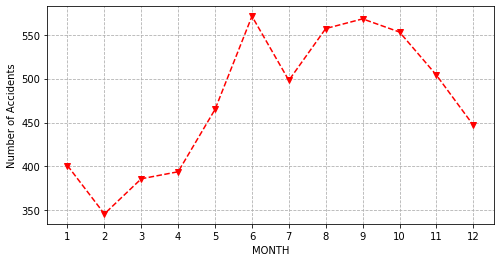

In [13]:
#Find no. of accident by year, use of the drop duplicates function since some accidents are are recorded more than once
monthtrend = trend.groupby([trend.index.month]).count()
fig, ax = plt.subplots(figsize=(8,4))
fig = plt.plot(monthtrend.index.values, monthtrend.ACCNUM, marker = 'v', linestyle='--', color='r')
plt.xlabel('MONTH'), plt.ylabel('Number of Accidents')
plt.grid(True, linestyle = '--'), plt.xticks(monthtrend.index.values)
plt.show()

We can see from the graph that there is a very low number of traffic accidents happening from December until April in Toronto, which are also winter months in Toronto where the temperature is lowest with a lot of snow days. This seems to correspond to the fact that people stay in more during winter, hence there are less number of accidents.

#### BY DAY OF THE WEEK

In [14]:
#Finding the day of the week of occurrences
trend2 = trend.copy()
trend2.index = trend2.index.dayofweek
#Create a data count table by day of the week
daytrend = trend2.groupby(trend2.index).count()
days = {0:'MON',1:'TUE',2:'WED',3:'THUR',4:'FRI',5:'SAT',6:'SUN'}
daytrend.index=daytrend.index.map(days)

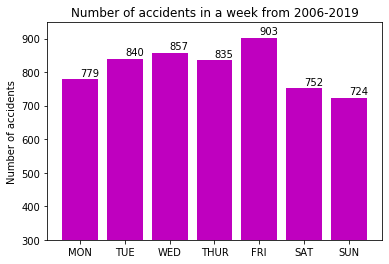

In [15]:
plt.bar(daytrend.index.values, daytrend.ACCNUM, color='m')
plt.title('Number of accidents in a week from 2006-2019')
plt.ylabel('Number of accidents')
plt.ylim(bottom = 300)
xlocs=plt.xticks()
for i, v in enumerate(daytrend.ACCNUM):
    plt.text(s= str(v), x = i, y=v+10)
plt.show()

From the bar chart above, we can see that there is a higher number of serious accidents on Friday. Assuming that it's the last day of the week so people tend to go out more at night, we can have a look at the data of those accidents happening on Friday only and see what time it usually occurred. 

#### LOOKING AT ACCIDENTS HAPPENING ON FRIDAY

In [16]:
#Finding the location of the accidents on Friday
y = list(trend2.loc[4]['ACCNUM'])
fridayaccident =data.loc[data['ACCNUM'].isin(y)]
fridayloc=fridayaccident[['ACCNUM', 'LONGITUDE', 'LATITUDE']].drop_duplicates()

In [17]:
map3=folium.Map(location=[43.708,-79.33], zoom_start=11, height=500, width=900, control_scale=True)
fridayloc.apply(lambda row:folium.CircleMarker(location=[row["LATITUDE"], row["LONGITUDE"]], radius=0.8).add_to(map3), axis=1)
map3

By looking at the map above, we can see a large number of accidents happening in the downtown area on Friday, which corresponds to party night for many people.

In [18]:
drunkFRI = fridayaccident.loc[fridayaccident.ALCOHOL=='Yes']
#Finding the location of the accidents on Friday
drunkFRI=drunkFRI[['ACCNUM', 'LONGITUDE', 'LATITUDE']].drop_duplicates()
map4=folium.Map(location=[43.708,-79.33], zoom_start=11, height=500, width=900, control_scale=True)
drunkFRI.apply(lambda row:folium.CircleMarker(location=[row["LATITUDE"], row["LONGITUDE"]], radius=0.8).add_to(map4), axis=1)
map4

We try to see where accident involving drunk people are located in the city and it appears like they are not necessarily in the downtown area alone but they are spread out around the city.

### BY LOCATION

In [19]:
#Count the number of accident in different Neighbourhoods
nbrank = data[['ACCNUM','Neighbourhood']].drop_duplicates().groupby(['Neighbourhood']).count().sort_values('ACCNUM', ascending=False)
nbrank.nlargest(5, 'ACCNUM')

ACCNUM
Neighbourhood                                 
Waterfront Communities-The Island (77)     205
West Humber-Clairville (1)                 166
Bay Street Corridor (76)                   134
Rouge (131)                                129
Woburn (137)                               116

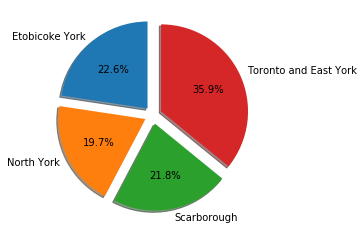

In [20]:
#Count the number of accident in different District
districtaccident = data[['ACCNUM','District']].drop_duplicates().groupby(['District']).count()
explode = (0.1, 0.1, 0.1, 0.1)
plt.pie(districtaccident.ACCNUM, explode = explode, labels=districtaccident.index.values, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

The highest number of accidents happening in Toronto and East York seems to coincide with the neighbourhood of Waterfront Communities-The Island (77) as this neighbourhood is located in this district.

### MAPPING IN ACCIDENTS BASED ON LATITUDE AND LONGITUDE

In [21]:
#Create a dataframe for the accident's latitude and longitude
mapdata = data[['ACCNUM', 'LATITUDE', 'LONGITUDE']].drop_duplicates()
mapdata

ACCNUM   LATITUDE  LONGITUDE
2006-01-01 02:36:00      893184  43.699595 -79.318797
2006-01-01 03:15:00      909646  43.684874 -79.316188
2006-01-02 07:05:00      884090  43.652892 -79.406253
2006-01-04 19:40:00      885782  43.655145 -79.433590
2006-01-06 22:10:00      882079  43.777056 -79.347858
...                         ...        ...        ...
2019-12-23 06:57:00  9002468442  43.678390 -79.464794
2019-12-23 14:15:00  9002471073  43.660304 -79.517086
2019-12-25 08:50:00  9002481518  43.775104 -79.347011
2019-12-27 23:24:00  9002496688  43.752475 -79.516483
2019-12-28 15:14:00  9002500260  43.658504 -79.384868

[5690 rows x 3 columns]

In [22]:
#Pinpointing the accidents in the map
map1=folium.Map(location=[43.708,-79.33], zoom_start=11, height=500, width=900, control_scale=True)
mapdata.apply(lambda row:folium.CircleMarker(location=[row["LATITUDE"], row["LONGITUDE"]], radius=0.8).add_to(map1), axis=1)
map1

The map above shows that our finding is quite accurate in terms of the location of the accidents, a lot of them occurred in the waterfront area of Toronto (strong cluster of accidents over the year)

### ROADCLASS WHERE ACCIDENTS ARE MOST LIKELY TO OCCUR

In [23]:
#Count the number of different ROAD_CLASS
data_road = data[['ACCNUM','ROAD_CLASS']].drop_duplicates().groupby(['ROAD_CLASS']).count().reset_index()
data_road = pd.DataFrame(data_road)
data_road = data_road.set_index('ROAD_CLASS')
data_road = data_road.rename(columns = {'ACCNUM': "Total accidents"})
data_road

Total accidents
ROAD_CLASS                          
Collector                        354
Expressway                         6
Laneway                            4
Local                            289
Major Arterial                  3981
Major Arterial Ramp                1
Minor Arterial                   931
Unknown/Other                    124

The Table shows that a large portion of the accidents happened in major arterials, which are defined by the City of Toronto as roads involving over 20,000 of daily motor vehicle traffic volume with higher speed limits than other roadclass but less speed limits than expressway.

Now we will have a look at how fatal the accidents that happened in the these different road class:

In [24]:
data1 = data[['ACCNUM', 'INJURY', 'ROAD_CLASS']]
data1 = data1.drop_duplicates()
table1 = data1.groupby('ROAD_CLASS').INJURY.value_counts().unstack().reset_index()
table1 = pd.DataFrame(table1, columns=['Fatal', 'ROAD_CLASS'])
table1 = table1.set_index('ROAD_CLASS')
table1= table1.replace(np.nan, 0 )
table1

Fatal
ROAD_CLASS                
Collector             49.0
Expressway             1.0
Laneway                3.0
Local                 44.0
Major Arterial       538.0
Major Arterial Ramp    0.0
Minor Arterial       107.0
Unknown/Other         24.0

In [25]:
result = pd.concat([data_road,table1], axis=1)
result

Total accidents  Fatal
ROAD_CLASS                                 
Collector                        354   49.0
Expressway                         6    1.0
Laneway                            4    3.0
Local                            289   44.0
Major Arterial                  3981  538.0
Major Arterial Ramp                1    0.0
Minor Arterial                   931  107.0
Unknown/Other                    124   24.0

In [26]:
#Create a table showing the rate of Fatal Accident by ROAD_CLASS
result['Rate of Fatal Accidents'] = result['Fatal']/result['Total accidents']
result

Total accidents  Fatal  Rate of Fatal Accidents
ROAD_CLASS                                                          
Collector                        354   49.0                 0.138418
Expressway                         6    1.0                 0.166667
Laneway                            4    3.0                 0.750000
Local                            289   44.0                 0.152249
Major Arterial                  3981  538.0                 0.135142
Major Arterial Ramp                1    0.0                 0.000000
Minor Arterial                   931  107.0                 0.114930
Unknown/Other                    124   24.0                 0.193548

Without looking at the rate of Fatal accidents for Unknown and Laneway, we can see that accidents happening on Expressway tend to be more fatal (0.166666) than major arterial (0.135) even though there are more accident happening on major arterial roads. A possible explanation for this could be the fact that people tend to drive faster on Expressway making it more fatal when collision occurs.

### LOOKING AT LOCATIONS WITH HIGH FREQUENCY OF ACCIDENTS

In [27]:
#Dropping Vehicle Owner from the data
data = data[data['INVTYPE']!='Vehicle Owner']
#Count the number of different addresses where accident occurred
addressgroup = data[['ACCNUM','ADDRESS']].drop_duplicates().groupby(['ADDRESS']).count()
#grouping addresses with high number of incident, more than 4
k = list(addressgroup.loc[addressgroup.ACCNUM>=5].index)
highaccident = data.loc[data['ADDRESS'].isin(k)]
#Count the number of addresses with higher frequency of accidents
highaccident['ACCNUM'].drop_duplicates().count()

451

In [28]:
#Most likely impacts seen in highaccident roads
highaccident[['ACCNUM','IMPACTYPE']].drop_duplicates().groupby(['IMPACTYPE']).count()

ACCNUM
IMPACTYPE                     
Angle                       41
Approaching                 10
Cyclist Collisions          28
Other                        7
Pedestrian Collisions      205
Rear End                    32
SMV Other                   37
SMV Unattended Vehicle       1
Sideswipe                    7
Turning Movement            82

We can see from the table above that the almost half (112 out of 234) of the location with high frequency of accidents are with pedestrian collisions.

In [29]:
#Pinpointing the accidents in the map
map1=folium.Map(location=[43.708,-79.33], zoom_start=11, height=500, width=900, control_scale=True)
highaccident.apply(lambda row:folium.CircleMarker(location=[row["LATITUDE"], row["LONGITUDE"]], radius=3).add_to(map1), axis=1)
map1

In [30]:
dataanalysis = data.drop(columns=['LATITUDE', 'District', 'LONGITUDE', 'Neighbourhood', 'ADDRESS', 'ObjectId', 'TRSN_CITY_VEH', 'TRSN_CITY_'])
dataanalysis.columns

Index(['ACCNUM', 'HOUR', 'ROAD_CLASS', 'LOCCOORD', 'TRAFFCTL', 'VISIBILITY',
       'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE',
       'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND',
       'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND',
       'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK',
       'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL',
       'DISABILITY', 'Hood_ID'],
      dtype='object')

In [31]:
data['INVTYPE'].unique()

array(['Passenger', 'Driver', 'Other Property Owner', 'Pedestrian',
       'Motorcycle Driver', 'Cyclist', 'Truck Driver', 'Unknown/Other',
       'In-Line Skater', 'Driver - Not Hit', 'Motorcycle Passenger',
       'Moped Driver', 'Wheelchair', 'Pedestrian - Not Hit',
       'Trailer Owner', 'Witness', 'Cyclist Passenger'], dtype=object)

In [32]:
compare1 = data[['INVTYPE', 'INJURY']]
compare1 = compare1.loc[compare1['INJURY']!= 'None']
compare1 = compare1.loc[compare1['INJURY']!= 'Unknown/Other']
compare1 = compare1.loc[compare1['INVTYPE']!= 'Unknown/Other']


compare1.INJURY=compare1.INJURY.replace(['Minor', 'Major', 'Minimal'], 'Non-Fatal')

In [33]:
compare1 = compare1.groupby('INVTYPE').INJURY.value_counts().unstack()

In [34]:
compare1 = compare1.replace(np.nan, 0)

In [35]:
compare1

INJURY                Fatal  Non-Fatal
INVTYPE                               
Cyclist                37.0      632.0
Cyclist Passenger       0.0        2.0
Driver                145.0     2578.0
Driver - Not Hit        0.0        1.0
In-Line Skater          0.0        4.0
Moped Driver            0.0       26.0
Motorcycle Driver      65.0      467.0
Motorcycle Passenger    1.0       28.0
Passenger              87.0     1581.0
Pedestrian            441.0     2251.0
Truck Driver            3.0       49.0
Wheelchair              2.0       11.0

In [36]:
fatal=compare1['Fatal']
non_fatal=compare1['Non-Fatal']
table = pd.crosstab(fatal, non_fatal)
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print (chi2, p)

95.99999999999999 0.262528152279769


No relationship between Involvement type and the fatality of the accident. 

In [37]:
compare2 = data[['AUTOMOBILE', 'INJURY']]
compare2 = compare2.loc[compare2['INJURY']!= 'None']
compare2 = compare2.loc[compare2['INJURY']!= 'Unknown/Other']
compare2.INJURY = compare2.INJURY.replace(['Minor', 'Major', 'Minimal'], 'Non-Fatal')

compare2

AUTOMOBILE     INJURY
2006-01-01 02:36:00        Yes  Non-Fatal
2006-01-01 02:36:00        Yes  Non-Fatal
2006-01-01 02:36:00        Yes  Non-Fatal
2006-01-01 02:36:00        Yes  Non-Fatal
2006-01-01 02:36:00        Yes  Non-Fatal
...                        ...        ...
2019-12-23 14:15:00        Yes  Non-Fatal
2019-12-23 14:15:00        Yes  Non-Fatal
2019-12-25 08:50:00        Yes  Non-Fatal
2019-12-27 23:24:00        Yes  Non-Fatal
2019-12-28 15:14:00        Yes  Non-Fatal

[8416 rows x 2 columns]

In [38]:
compare2=compare2.groupby('AUTOMOBILE').INJURY.value_counts().unstack()
compare2

INJURY      Fatal  Non-Fatal
AUTOMOBILE                  
No            130        587
Yes           651       7048

In [39]:
yes_fatal = compare2['Fatal']
no_fatal = compare2['Non-Fatal']
table_auto = pd.crosstab(yes_fatal, no_fatal)
chi2_2, p_2, dof_2, expected_2 = chi2_contingency(table_auto.values)
print (chi2_2, p_2)

0.0 1.0


In [40]:
compare3 = data[['INVAGE', 'INJURY']]
compare3 = compare3.loc[compare3['INJURY']!= 'None']
compare3 = compare3.loc[compare3['INJURY']!= 'Unknown/Other']
compare3.INJURY = compare3.INJURY.replace(['Minor', 'Major', 'Minimal'], 'Non-Fatal')

compare3

INVAGE     INJURY
2006-01-01 02:36:00  50 to 54  Non-Fatal
2006-01-01 02:36:00  15 to 19  Non-Fatal
2006-01-01 02:36:00  55 to 59  Non-Fatal
2006-01-01 02:36:00  20 to 24  Non-Fatal
2006-01-01 02:36:00  15 to 19  Non-Fatal
...                       ...        ...
2019-12-23 14:15:00  55 to 59  Non-Fatal
2019-12-23 14:15:00  15 to 19  Non-Fatal
2019-12-25 08:50:00  35 to 39  Non-Fatal
2019-12-27 23:24:00  10 to 14  Non-Fatal
2019-12-28 15:14:00  25 to 29  Non-Fatal

[8416 rows x 2 columns]

In [41]:
compare3 = compare3.groupby('INVAGE').INJURY.value_counts().unstack()
compare3

INJURY         Fatal  Non-Fatal
INVAGE                         
0 to 4             3         84
10 to 14           4        156
15 to 19          38        495
20 to 24          60        906
25 to 29          60        810
30 to 34          47        643
35 to 39          40        588
40 to 44          44        569
45 to 49          37        557
5 to 9            11        103
50 to 54          39        599
55 to 59          59        482
60 to 64          41        383
65 to 69          47        328
70 to 74          59        266
75 to 79          55        237
80 to 84          58        168
85 to 89          50        116
90 to 94          21         26
Over 95            6          2
Unknown/Other      2        117

In [42]:
fatal1=compare3['Fatal']
non_fatal1=compare3['Non-Fatal']
table3 = pd.crosstab(fatal1, non_fatal1)
from scipy.stats import chi2_contingency
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(table3.values)
print (chi2_3, p_3)

357.0 0.2524418111398984


In [43]:
compare3 = data[['ALCOHOL', 'INJURY']]
compare3 = compare3.loc[compare3['INJURY']!= 'None']
compare3 = compare3.loc[compare3['INJURY']!= 'Unknown/Other']
compare3.INJURY = compare3.INJURY.replace(['Minor', 'Major', 'Minimal'], 'Non-Fatal')

compare3

ALCOHOL     INJURY
2006-01-01 02:36:00     Yes  Non-Fatal
2006-01-01 02:36:00     Yes  Non-Fatal
2006-01-01 02:36:00     Yes  Non-Fatal
2006-01-01 02:36:00     Yes  Non-Fatal
2006-01-01 02:36:00     Yes  Non-Fatal
...                     ...        ...
2019-12-23 14:15:00      No  Non-Fatal
2019-12-23 14:15:00      No  Non-Fatal
2019-12-25 08:50:00      No  Non-Fatal
2019-12-27 23:24:00      No  Non-Fatal
2019-12-28 15:14:00      No  Non-Fatal

[8416 rows x 2 columns]

In [44]:
compare3 = compare3.groupby('ALCOHOL').INJURY.value_counts().unstack()
compare3

INJURY   Fatal  Non-Fatal
ALCOHOL                  
No         744       7221
Yes         37        414

In [45]:
fatal1=compare3['Fatal']
non_fatal1=compare3['Non-Fatal']
table3 = pd.crosstab(fatal1, non_fatal1)
from scipy.stats import chi2_contingency
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(table3.values)
print (chi2_3, p_3)

0.0 1.0


In [46]:
compare3 = data[['IMPACTYPE', 'INJURY']]
compare3 = compare3.loc[compare3['INJURY']!= 'None']
compare3 = compare3.loc[compare3['INJURY']!= 'Unknown/Other']
compare3.INJURY = compare3.INJURY.replace(['Minor', 'Major', 'Minimal'], 'Non-Fatal')

compare3

IMPACTYPE     INJURY
2006-01-01 02:36:00            Approaching  Non-Fatal
2006-01-01 02:36:00            Approaching  Non-Fatal
2006-01-01 02:36:00            Approaching  Non-Fatal
2006-01-01 02:36:00            Approaching  Non-Fatal
2006-01-01 02:36:00            Approaching  Non-Fatal
...                                    ...        ...
2019-12-23 14:15:00       Turning Movement  Non-Fatal
2019-12-23 14:15:00       Turning Movement  Non-Fatal
2019-12-25 08:50:00  Pedestrian Collisions  Non-Fatal
2019-12-27 23:24:00  Pedestrian Collisions  Non-Fatal
2019-12-28 15:14:00  Pedestrian Collisions  Non-Fatal

[8416 rows x 2 columns]

In [47]:
compare3 = compare3.groupby('IMPACTYPE').INJURY.value_counts().unstack()
compare3

INJURY                  Fatal  Non-Fatal
IMPACTYPE                               
Angle                      36        658
Approaching                39        530
Cyclist Collisions         37        681
Other                       5         81
Pedestrian Collisions     446       2516
Rear End                   22        828
SMV Other                 104        725
SMV Unattended Vehicle      9         67
Sideswipe                   8        222
Turning Movement           74       1325

In [48]:
fatal1=compare3['Fatal']
non_fatal1=compare3['Non-Fatal']
table3 = pd.crosstab(fatal1, non_fatal1)
from scipy.stats import chi2_contingency
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(table3.values)
print (chi2_3, p_3)

89.99999999999999 0.23134171389514135


In [49]:
compare3 = data[['LOCCOORD', 'VISIBILITY']]
compare3 = compare3.loc[compare3['LOCCOORD']!= 'Unknown/Other']
compare3 = compare3.loc[compare3['VISIBILITY']!= 'Unknown/Other']
compare3
compare3

LOCCOORD VISIBILITY
2006-01-01 02:36:00  Intersection      Clear
2006-01-01 02:36:00  Intersection      Clear
2006-01-01 02:36:00  Intersection      Clear
2006-01-01 02:36:00  Intersection      Clear
2006-01-01 02:36:00  Intersection      Clear
...                           ...        ...
2019-12-27 23:24:00     Mid-Block      Clear
2019-12-27 23:24:00     Mid-Block      Clear
2019-12-28 15:14:00  Intersection      Clear
2019-12-28 15:14:00  Intersection      Clear
2019-12-28 15:14:00  Intersection      Clear

[14244 rows x 2 columns]

In [50]:
compare3 = compare3.groupby('LOCCOORD').VISIBILITY.value_counts().unstack()
compare3 = compare3.replace(np.nan, 0)
compare3

VISIBILITY                            Clear  Drifting Snow  \
LOCCOORD                                                     
Entrance Ramp Westbound                 2.0            0.0   
Exit Ramp Southbound                    2.0            0.0   
Exit Ramp Westbound                     4.0            0.0   
Intersection                         8158.0            7.0   
Mid-Block                            4156.0           11.0   
Mid-Block (Abnormal)                    0.0            0.0   
Park, Private Property, Public Lane     2.0            0.0   

VISIBILITY                           Fog, Mist, Smoke, Dust  Freezing Rain  \
LOCCOORD                                                                     
Entrance Ramp Westbound                                 0.0            0.0   
Exit Ramp Southbound                                    0.0            0.0   
Exit Ramp Westbound                                     0.0            0.0   
Intersection                                           26.0           19.0   
Mid-Block                                              13.0           18.0   
Mid-Block (Abnormal)                                    0.0            0.0   
Park, Private Property, Public Lane                     0.0            0.0   

VISIBILITY                             Rain   Snow  Strong wind  
LOCCOORD                                                         
Entrance Ramp Westbound                 0.0    0.0          0.0  
Exit Ramp Southbound                    0.0    0.0          0.0  
Exit Ramp Westbound                     0.0    0.0          0.0  
Intersection                         1077.0  145.0          4.0  
Mid-Block                             448.0  146.0          2.0  
Mid-Block (Abnormal)                    4.0    0.0          0.0  
Park, Private Property, Public Lane     0.0    0.0          0.0

In [51]:
dataanalysis.columns

Index(['ACCNUM', 'HOUR', 'ROAD_CLASS', 'LOCCOORD', 'TRAFFCTL', 'VISIBILITY',
       'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE',
       'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND',
       'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND',
       'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK',
       'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL',
       'DISABILITY', 'Hood_ID'],
      dtype='object')

In [52]:
compare3 = data[['ROAD_CLASS', 'ALCOHOL']]
compare3 = compare3.loc[compare3['ROAD_CLASS']!= 'None']
compare3 = compare3.loc[compare3['ROAD_CLASS']!= 'Unknown/Other']
compare3

ROAD_CLASS ALCOHOL
2006-01-01 02:36:00  Major Arterial     Yes
2006-01-01 02:36:00  Major Arterial     Yes
2006-01-01 02:36:00  Major Arterial     Yes
2006-01-01 02:36:00  Major Arterial     Yes
2006-01-01 02:36:00  Major Arterial     Yes
...                             ...     ...
2019-12-27 23:24:00  Major Arterial      No
2019-12-27 23:24:00  Major Arterial      No
2019-12-28 15:14:00  Major Arterial      No
2019-12-28 15:14:00  Major Arterial      No
2019-12-28 15:14:00  Major Arterial      No

[14103 rows x 2 columns]

In [45]:
compare3 = compare3.groupby('ROAD_CLASS').ALCOHOL.value_counts().unstack()
compare3 = compare3.replace(np.nan, 0)
compare3

ALCOHOL                  No    Yes
ROAD_CLASS                        
Collector             737.0   57.0
Expressway             24.0    0.0
Laneway                10.0    0.0
Local                 641.0   10.0
Major Arterial       9944.0  443.0
Major Arterial Ramp     1.0    0.0
Minor Arterial       2156.0   80.0

In [46]:
not_drunk=compare3['No']
drunk=compare3['Yes']
table3 = pd.crosstab(not_drunk, drunk)
from scipy.stats import chi2_contingency
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(table3.values)
print (chi2_3, p_3)

28.000000000000007 0.2600399224594336


In [47]:
compare3 = data[['Neighbourhood', 'ALCOHOL']]
compare3

Neighbourhood ALCOHOL
2006-01-01 02:36:00        Woodbine-Lumsden (60)     Yes
2006-01-01 02:36:00        Woodbine-Lumsden (60)     Yes
2006-01-01 02:36:00        Woodbine-Lumsden (60)     Yes
2006-01-01 02:36:00        Woodbine-Lumsden (60)     Yes
2006-01-01 02:36:00        Woodbine-Lumsden (60)     Yes
...                                          ...     ...
2019-12-27 23:24:00  Glenfield-Jane Heights (25)      No
2019-12-27 23:24:00  Glenfield-Jane Heights (25)      No
2019-12-28 15:14:00     Bay Street Corridor (76)      No
2019-12-28 15:14:00     Bay Street Corridor (76)      No
2019-12-28 15:14:00     Bay Street Corridor (76)      No

[14457 rows x 2 columns]

In [48]:
compare3 = compare3.groupby('Neighbourhood').ALCOHOL.value_counts().unstack()
compare3 = compare3.replace(np.nan, 0)
compare3

ALCOHOL                                No   Yes
Neighbourhood                                  
Agincourt North (129)               145.0   5.0
Agincourt South-Malvern West (128)  142.0   0.0
Alderwood (20)                       57.0   7.0
Annex (95)                          185.0   9.0
Banbury-Don Mills (42)              143.0  19.0
...                                   ...   ...
Wychwood (94)                        92.0   0.0
Yonge-Eglinton (100)                 45.0   4.0
Yonge-St.Clair (97)                  46.0   0.0
York University Heights (27)        205.0   9.0
Yorkdale-Glen Park (31)             102.0   3.0

[140 rows x 2 columns]

In [49]:
not_drunk=compare3['No']
drunk=compare3['Yes']
table3 = pd.crosstab(not_drunk, drunk)
from scipy.stats import chi2_contingency
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(table3.values)
print (chi2_3, p_3)

2328.8207547169814 9.225194703874935e-05


In [50]:
alcoholmap = data[['ACCNUM', 'LONGITUDE', 'LATITUDE', 'ALCOHOL']].drop_duplicates()
alcoholmap = alcoholmap.loc[alcoholmap['ALCOHOL']=='Yes']
alcoholmap

ACCNUM  LONGITUDE   LATITUDE ALCOHOL
2006-01-01 02:36:00      893184 -79.318797  43.699595     Yes
2006-07-23 05:15:00      915114 -79.578790  43.679345     Yes
2006-07-24 23:48:00      919231 -79.337690  43.700245     Yes
2006-08-03 01:22:00      916979 -79.471690  43.634145     Yes
2006-03-06 22:22:00      891993 -79.481490  43.627745     Yes
...                         ...        ...        ...     ...
2018-12-24 20:50:00  8002355627 -79.590541  43.737025     Yes
2019-07-30 00:39:00  9001431003 -79.385296  43.655410     Yes
2019-09-04 17:22:00  9001693858 -79.304439  43.718898     Yes
2019-09-08 01:06:00  9001718859 -79.400074  43.644447     Yes
2019-09-24 03:21:00  9001837052 -79.564709  43.674197     Yes

[221 rows x 4 columns]

In [51]:
#Pinpointing the accidents in the map
map5=folium.Map(location=[43.708,-79.33], zoom_start=11, height=500, width=900, control_scale=True)
alcoholmap.apply(lambda row:folium.CircleMarker(location=[row["LATITUDE"], row["LONGITUDE"]], radius=3).add_to(map5), axis=1)
map1

In [52]:
compare3 = compare3.loc[compare3['Yes']>0]
compare3

ALCOHOL                          No   Yes
Neighbourhood                            
Agincourt North (129)         145.0   5.0
Alderwood (20)                 57.0   7.0
Annex (95)                    185.0   9.0
Banbury-Don Mills (42)        143.0  19.0
Bathurst Manor (34)           102.0   7.0
...                             ...   ...
Woburn (137)                  302.0  25.0
Woodbine-Lumsden (60)          32.0   7.0
Yonge-Eglinton (100)           45.0   4.0
York University Heights (27)  205.0   9.0
Yorkdale-Glen Park (31)       102.0   3.0

[87 rows x 2 columns]

In [53]:
data['INJURY'].unique()

array(['Major', 'Minor', 'None', 'Unknown/Other', 'Fatal', 'Minimal'],
      dtype=object)

In [54]:
data['ACCLASS'].unique()

array(['Non-Fatal Injury', 'Fatal'], dtype=object)

In [55]:
len(list(data['ACCNUM'].unique()))

5690

In [56]:
data

ACCNUM      ROAD_CLASS               District  \
2006-01-01 02:36:00      893184  Major Arterial  Toronto and East York   
2006-01-01 02:36:00      893184  Major Arterial  Toronto and East York   
2006-01-01 02:36:00      893184  Major Arterial  Toronto and East York   
2006-01-01 02:36:00      893184  Major Arterial  Toronto and East York   
2006-01-01 02:36:00      893184  Major Arterial  Toronto and East York   
...                         ...             ...                    ...   
2019-12-27 23:24:00  9002496688  Major Arterial         Etobicoke York   
2019-12-27 23:24:00  9002496688  Major Arterial         Etobicoke York   
2019-12-28 15:14:00  9002500260  Major Arterial  Toronto and East York   
2019-12-28 15:14:00  9002500260  Major Arterial  Toronto and East York   
2019-12-28 15:14:00  9002500260  Major Arterial  Toronto and East York   

                      LATITUDE  LONGITUDE      LOCCOORD        TRAFFCTL  \
2006-01-01 02:36:00  43.699595 -79.318797  Intersection      No Control   
2006-01-01 02:36:00  43.699595 -79.318797  Intersection      No Control   
2006-01-01 02:36:00  43.699595 -79.318797  Intersection      No Control   
2006-01-01 02:36:00  43.699595 -79.318797  Intersection      No Control   
2006-01-01 02:36:00  43.699595 -79.318797  Intersection      No Control   
...                        ...        ...           ...             ...   
2019-12-27 23:24:00  43.752475 -79.516483     Mid-Block      No Control   
2019-12-27 23:24:00  43.752475 -79.516483     Mid-Block      No Control   
2019-12-28 15:14:00  43.658504 -79.384868  Intersection  Traffic Signal   
2019-12-28 15:14:00  43.658504 -79.384868  Intersection  Traffic Signal   
2019-12-28 15:14:00  43.658504 -79.384868  Intersection  Traffic Signal   

                    VISIBILITY             LIGHT RDSFCOND  ... PASSENGER  \
2006-01-01 02:36:00      Clear              Dark      Wet  ...       Yes   
2006-01-01 02:36:00      Clear              Dark      Wet  ...       Yes   
2006-01-01 02:36:00      Clear              Dark      Wet  ...       Yes   
2006-01-01 02:36:00      Clear              Dark      Wet  ...       Yes   
2006-01-01 02:36:00      Clear              Dark      Wet  ...       Yes   
...                        ...               ...      ...  ...       ...   
2019-12-27 23:24:00      Clear  Dark, artificial      Dry  ...        No   
2019-12-27 23:24:00      Clear  Dark, artificial      Dry  ...        No   
2019-12-28 15:14:00      Clear          Daylight      Dry  ...        No   
2019-12-28 15:14:00      Clear          Daylight      Dry  ...        No   
2019-12-28 15:14:00      Clear          Daylight      Dry  ...        No   

                    SPEEDING AG_DRIV REDLIGHT ALCOHOL DISABILITY  \
2006-01-01 02:36:00      Yes     Yes       No     Yes         No   
2006-01-01 02:36:00      Yes     Yes       No     Yes         No   
2006-01-01 02:36:00      Yes     Yes       No     Yes         No   
2006-01-01 02:36:00      Yes     Yes       No     Yes         No   
2006-01-01 02:36:00      Yes     Yes       No     Yes         No   
...                      ...     ...      ...     ...        ...   
2019-12-27 23:24:00       No     Yes       No      No         No   
2019-12-27 23:24:00       No     Yes       No      No         No   
2019-12-28 15:14:00       No     Yes      Yes      No         No   
2019-12-28 15:14:00       No     Yes      Yes      No         No   
2019-12-28 15:14:00       No     Yes      Yes      No         No   

                                   Neighbourhood ObjectId  \
2006-01-01 02:36:00        Woodbine-Lumsden (60)        1   
2006-01-01 02:36:00        Woodbine-Lumsden (60)        2   
2006-01-01 02:36:00        Woodbine-Lumsden (60)        3   
2006-01-01 02:36:00        Woodbine-Lumsden (60)        4   
2006-01-01 02:36:00        Woodbine-Lumsden (60)        5   
...                                          ...      ...   
2019-12-27 23:24:00  Glenfield-Jane Heights (25)    16089   
2019-12-27 23:24:

In [57]:
data['INVTYPE']

2006-01-01 02:36:00     Passenger
2006-01-01 02:36:00     Passenger
2006-01-01 02:36:00        Driver
2006-01-01 02:36:00     Passenger
2006-01-01 02:36:00     Passenger
                          ...    
2019-12-27 23:24:00        Driver
2019-12-27 23:24:00    Pedestrian
2019-12-28 15:14:00        Driver
2019-12-28 15:14:00        Driver
2019-12-28 15:14:00    Pedestrian
Name: INVTYPE, Length: 14457, dtype: object